<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/L8/OpenCVfaceDetector%E3%81%AB%E3%82%88%E3%82%8B%E9%A1%94%E6%A4%9C%E5%87%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow
import urllib.request

# モデルデータとライブラリの読み込み

In [2]:
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
!wget -q https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/opencv_face_detector.prototxt
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/common.py

# 顔検出用ネットワークの構成

In [3]:
# Load a network
model = 'res10_300x300_ssd_iter_140000.caffemodel'
config = 'opencv_face_detector.prototxt'
framework = 'caffe'
net = cv2.dnn.readNet(model=model, config=config, framework=framework)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
outNames = net.getUnconnectedOutLayersNames()
confThreshold = 0.5 # Confidence threshold (default: 0.5)
# nmsThreshold = 0.4 # Non-maximum suppression threshold (default: 0.4)
# 以下の値は、models.yml (https://github.com/opencv/opencv/blob/master/samples/dnn/models.yml) より
scale=1.0
width= 300
height= 300
mean= [104, 177, 123]
rgb=False

# 実験用顔画像


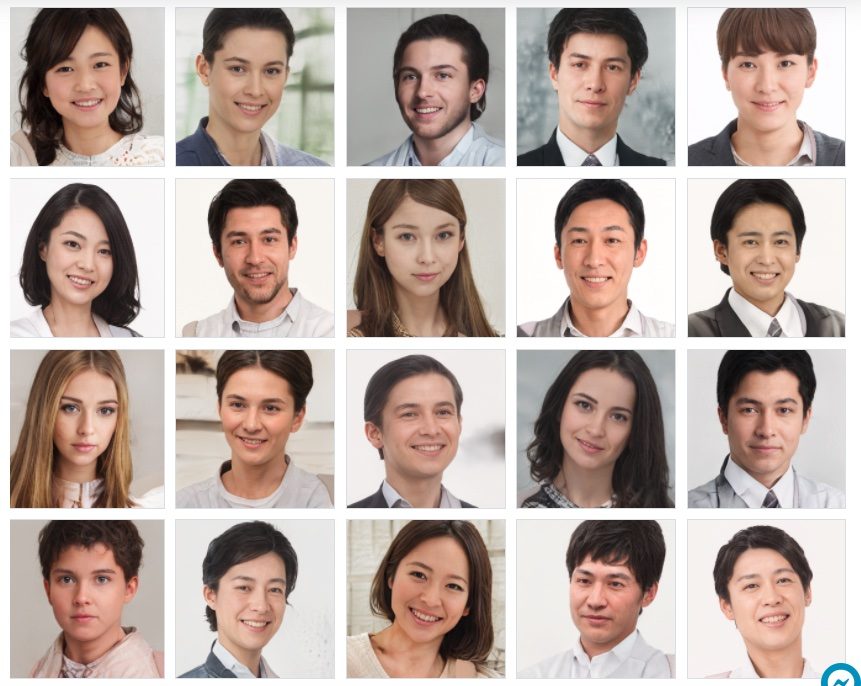

In [4]:
url = 'https://user-images.githubusercontent.com/24559785/122865368-405c2080-d361-11eb-96fa-c031a7044eb8.jpg'
pic1,header=urllib.request.urlretrieve(url)
inputimg = cv2.imread(pic1,1)
cv2_imshow(inputimg)


# 顔の検出

In [5]:
# 入力画像を 4D blob 形式に変換する。 opencv facedetector の入力は 300x300なので、そのサイズにリサイズ
blob = cv2.dnn.blobFromImage(inputimg, size=(width, height), swapRB=rgb, ddepth=cv2.CV_8U)
# 入力画像データをネットワークにセット、　学習時のRGB値の平均値をセット
net.setInput(blob,scalefactor=scale,mean=mean)
# 顔検出結果を得る　＝＞ results
results = net.forward(outNames)[0][0,0]

### results の値
results は、
0. batchId  
1. classId  
2. 信頼度(confidence)　　　　
3. left  矩形左上頂点のｘ座標   
4. top  矩形左上頂点のy座標   
5. right  右下頂点のx座標
6. bottom 右下頂点のｙ座標
のリストである。

In [6]:
results[0]

array([0.        , 1.        , 0.9983725 , 0.84528744, 0.79591185,
       0.93602145, 0.93804246], dtype=float32)

# 信頼性の高い候補の抽出
検出された矩形情報は高さと幅を１とする相対値であり区間[0,1]の浮動小数点数となっている。

確信度の低い矩形もあるので、確信度がconfThreshold（デフォルトでは0.5）を超えるものだけ抽出する。

In [30]:
confThreshold = 0.92 #@param {type:"slider", min:0, max:1, step:0.01}
classIds = []
confidences = []
faces = []
frameHeight,frameWidth = inputimg.shape[:2]
for detection in results:
    confidence = detection[2] # 確信度
    if confidence > confThreshold:
        left = int(detection[3] * frameWidth) # 左端の位置を整数化ｌ．以下同様
        top = int(detection[4] * frameHeight)
        right = int(detection[5] * frameWidth)
        bottom = int(detection[6] * frameHeight)
        width = right - left + 1
        height = bottom - top + 1
        confidences.append(float(confidence))
        faces.append([left, top, width, height])
print(f"{len(faces)}人の顔が見つかりました") # 

20人の顔が見つかりました


# 顔の切り出し

In [35]:
# 切り出し
faceimgs = []
for x,y,w,h in faces:
  img0 = np.zeros((h,w,3),np.uint8)
  img0 = inputimg[y:y+h,x:x+w]
  faceimgs.append(img0)

# 表示用関数を定義
import matplotlib.pyplot as plt
def showf(n,withConf=True):
  plt.imshow(faceimgs[n][:,:,::-1])
  if withConf:
    print(f"確信度は{results[i][2]}")

確信度は0.9481462240219116


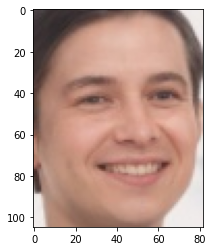

In [36]:
# 3番目だけ表示 
showf(3)

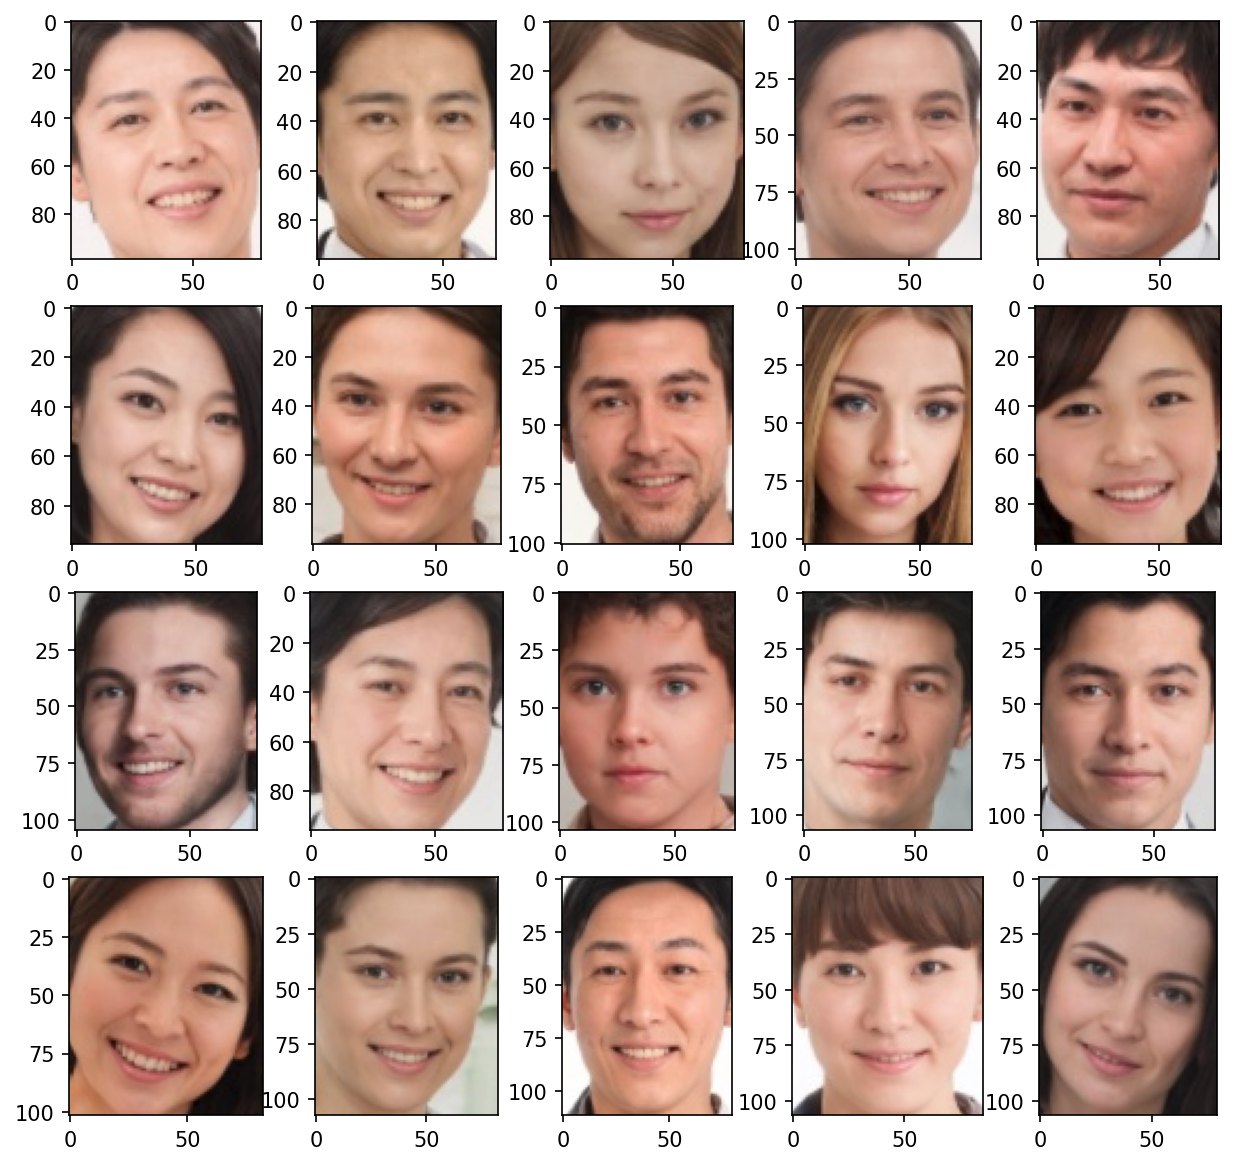

In [37]:
# 検出された顔をすべて出力
plt.figure(figsize=(10,50),dpi=150)
row=1
for i in range(len(faceimgs)):
  plt.subplot(5*((len(faces)-1)//5+1),5,i+1)
  showf(i,withConf=False)